# Genetic Algorithms

*The last unit of the course book deals with an **optimization technique** known as **Genetic Algorithms (GA)**.* *The basic idea here is to randomly change current updates through **Selection**, **Crossover/Mating** and **Mutation**.*These techniques help in order not to get stuck in a local optimum until the best solution is reached.*

The final state maximizes the **fitness function**, i.e. it minimizes the cost function. 

Another prominent optimization technique is **gradient descent**, heavily used in machine-learning.

The advantages of GA are:

* Optimize with continuous or discrete variables 
* Does not need derivative information
* Well suited for parallel computing
* Optimizes variables with extremely complex cost surfaces

![](algorithm.png)

Here we follow *Practical Genetic Algorithms* by Randy L. Haupt, Sue Ellen Haupt, 2004, John Wiley & Sons.

# Preamble

In [1]:
# Common imports
import numpy as np # numpy is THE toolbox for scientific computing with python
import pandas as pd # pandas provides THE data structure and data analysis tools for data scientists 

# maximum number of columns
pd.set_option("display.max_rows", 101)
pd.set_option("display.max_columns", 101)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from warnings import filterwarnings
filterwarnings('ignore')

# The Knapsack Problem

We have a bag which can carry 35 kgs of weight. We can choose between 10 items, each with a specifc weight and price. We want to pick the items which maximize the value, i.e. the total price without exceeding the knapsack weight.

In [153]:
np.random.seed(42)
item_number = np.arange(1,11)
weight      = np.random.randint(1,15, size = 10)
value       = np.random.randint(10,750, size = 10)
knapsack_threshold = 35

df = pd.DataFrame({'item_number':item_number,
                   'weight':weight,
                   'value':value})
df

,item_number,weight,value
0,1,7,224
1,2,4,340
2,3,13,468
3,4,11,97
4,5,8,382
5,6,13,109
6,7,5,673
7,8,7,140
8,9,10,671
9,10,3,318


**Target**: Pick the items (item_number) which have highest value and do not exceed weight threshold.

## Setting the Scene

The GA begins with defining a chromosome (i.e an array of variable values) to be optimized:
$$ [p_1, p_2, \ldots, p_N] $$

For the knapsack problem it means if an item should be put into the bag or not:
$$ [1,0, 0, 0, 0,0,0,0,0,1] $$

*Note:* Binary Encoding is just one possible representation of chromosomes. For instance, in odering problems liek the traveling salesman problem permutation encoding is used.

The cost function $f$ is given as:
$$ cost = f(p_1, p_2, \ldots, p_N) $$

The GA starts with a group of chromosomes referred to as the **population**.

A population is evolved from one **generation** to the next and only the fittest survive. The selection rate $X_{rate}$ is the fraction of the population $N_{pop}$ that survives. The number of chromosomes kept is:

$$ N_{keep} = X_{rate} N_{pop} $$

We often keep $50 \%$ ($X_{rate} = 0.5$) in the natural selection process. 

In [154]:
solutions_per_pop  = 8
# pop_size           = (solutions_per_pop, df.shape[0])
initial_population = np.random.randint(2, size = pop_size).astype(int)
num_generations    = 50

print('Our initial population : \n \n', initial_population)

Our initial population : 
 
 [[1 1 1 1 1 1 1 1 0 0]
 [1 1 1 0 1 0 0 0 0 0]
 [1 1 1 1 1 0 1 1 0 1]
 [0 1 0 1 1 0 0 0 0 0]
 [0 0 0 1 1 0 1 1 1 1]
 [0 1 0 1 1 1 0 1 0 1]
 [0 1 0 0 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 0 0 1]]


In [476]:
print('\n Selected items in our first chromosome of our starting population: \n')

weight_vec = [];
value_vec  = [];
for i in range(len(initial_population[0])):
    if initial_population[0][i] != 0:
        print('{}\n'.format(item_number[i]))
        weight_vec.append(weight[i])
        value_vec.append(value[i])
print('\n with total weight: \n')
print(np.array(weight_vec).sum())
print('\n and total value: \n')
print(np.array(value_vec).sum())


 Selected items in our first chromosome of our starting population: 

1

2

3

4

5

6

7

8


 with total weight: 

68

 and total value: 

2433


The *fitness function of the knapsack problem* calculates the total value and the total weight. It is the total value of the chosen items, if the weight does not exceed the upper bound:

$$ f(p_1, p_2, \ldots, p_8) = \sum_{i=1}^{8} p_i v_i $$

$$ \sum_{i=1}^8 p_j w_j \leq M $$

In [342]:
def cal_fitness(weight, value, population, threshold):
    
    fitness = np.empty(population.shape[0])
    
    for i in range(population.shape[0]):
        S1 = np.sum(population[i] * value)
        S2 = np.sum(population[i] * weight)
        if S2 <= threshold:
            fitness[i] = S1
        else:
            fitness[i] = 0 
    #print(fitness)

    return(pd.DataFrame({'fitness': fitness}))

In [478]:
fitness_df = cal_fitness(weight, value, initial_population, knapsack_threshold)
fitness_df
#print('Our first individual has a fitness of : ', fitness[0])

,fitness
0,0.0
1,1414.0
2,0.0
3,819.0
4,0.0
5,0.0
6,0.0
7,0.0


In [285]:
value

array([224, 340, 468,  97, 382, 109, 673, 140, 671, 318])

In [479]:
fitness_df.sort_values('fitness', ascending=False).reset_index()

,index,fitness
0,1,1414.0
1,3,819.0
2,0,0.0
3,2,0.0
4,4,0.0
5,5,0.0
6,6,0.0
7,7,0.0


Finally, only the fittest survive. 

## Selection

From the $N_{keep}$ chromosomes new offsprins are constructed. Pairing takes place unitl $N_{pop}-N_{keep}$ offsprings are born to replace the discarded chromosomes.

Pairing chromosomes in a GA can be as interesting and varied as pairing in an animal species. Different selection methods are:

* Pairing from top to bottom
* Random pairing
* Weighted random pairing
* Cost weighting: The probability of selection is calculated from the cost of the chromosome rather than its rank in the population. 
* Tournament selection

In [302]:
def selection(fitness_df, population, num_parents):
    
    parents_df = fitness_df.sort_values('fitness', ascending=False).reset_index()[:num_parents]
    parents    = population[parents_df['index']]
    return(parents)

In [303]:
selection_df = selection(fitness_df, initial_population, int(pop_size[0]/2))

In [305]:
selection_df

array([[1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 1, 0, 1, 1, 0, 1]])

In [ ]:
# def selection(fitness, num_parents, population):
#     fitness = list(fitness)
#     parents = np.empty((num_parents, population.shape[1]))
#     for i in range(num_parents):
#         max_fitness_idx = np.where(fitness == np.max(fitness))
#         print(max_fitness_idx)
#         parents[i,:] = population[max_fitness_idx[0][0], :]
#         fitness[max_fitness_idx[0][0]] = -999999
#     return(parents)

## Mating/Crossover

Mating is the creation of one of more offspring from the parents selected in the pairing process. 

A simple version of mating (*single-point crossover*):

A crossover point can be randomly selected between the first and lasts bits of hte parents' chromosomes. First, $parent_1$ passes its binary code to the left of that corrover point to $offspring_1$. Then $parent_2$ passes its binary code to the left of the same crossover point to $offspring_2$. Next, the binary code to the right of the crossover point of $parent_1$ goes to $offspring_2$ and $parent_2$ passes its code to $offspring_1$.

There exist much more involved versions of mating.

![](mating.png)

In [176]:
selection_df[random.randint(0,len(parents)-1)]

array([1, 1, 1, 0, 1, 0, 0, 0, 0, 0])

In [237]:
# CROSS-OVER
random.seed(42)
parents = selection_df;

children = []
#number of child chromosomes:
desired_length = solutions_per_pop - len(parents)
print(desired_length)

while len(children) < desired_length :
    male   = list(selection_df[random.randint(0,len(parents)-1)])
    print(male)
    female = list(selection_df[random.randint(0,len(parents)-1)])
    print(female)
    half = int(len(male)/2)
    child = male[:half] + female[half:]
    print(child)
    children.append(child)
    print("=====================")

4
[1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
[1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0]
[1, 1, 0, 1, 0, 1, 1, 0, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
[0, 1, 0, 1, 1, 0, 0, 0, 0, 0]
[1, 1, 0, 1, 0, 1, 1, 0, 1, 0]
[0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
[1, 1, 1, 0, 1, 0, 0, 0, 0, 0]
[1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
[1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


## Mutation

Random mutations alter a certain percentage of the bits in the list of chromosomes. Mutation is the second way a GA explores a cost surface. It can introduce traits not in the original population and keeps the GA from converging too fast before sampling the entire cost surface. A single point mutation changes a 1 to a 0 and visa sersa. 

Increasing the number of mutations increases the algorithms freedom to search outside the current region of variable space. It also tends to distract algorithms from converging on a popular solution. **Mutations do not occur on the final solution.**

Do we allow mutations on the best solution? Generally not. So a ruel could be: Mutate 20% of the population except the best chromosome. How many mutations would therefore occur?

$$ 0.2 \cdot (N_{pop} -1 ) \cdot N_{bits} = 0.2 \cdot 7 \cdot 10 \sim 14 \, \text{mutations}$$

In [486]:
random.random()

0.6501668602735652

In [258]:
random.seed(42)
mutation_chance = 0.08

# Mutation
for child in children:
    print(child)
    if mutation_chance > random.random():
        r = random.randint(0,len(child)-1)
        if child[r] == 1:
            child[r] = 0
        else:
            child[r] = 1
    print(child)
    print("===================")

[1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
[1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
[1, 1, 1, 1, 1, 1, 1, 0, 1, 0]
[1, 1, 1, 1, 0, 1, 1, 0, 1, 0]
[0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
[0, 1, 0, 1, 1, 1, 1, 0, 1, 0]
[1, 1, 1, 0, 1, 1, 1, 0, 1, 0]
[1, 1, 1, 0, 1, 1, 1, 0, 1, 0]


## The Next Generation & Convergence

After the mutations take place, the costs associated with the offspring and mutated chromosomes are calculated. 

After a while all the chromosomes and associated costs would become the same if it were not for mutations. At this point the algorithm should be stopped. 

In [471]:
def optimize(weight, value, population, num_generations, knapsack_threshold):
        
    pop_size = len(population[0])
    
    fitness_history = [];
    for i in range(num_generations):
        print('Generation : ', i)
        print(population)
        fitness_df = cal_fitness(weight, value, population, knapsack_threshold)
#        print(fitness_df)
        parents_df = selection(fitness_df, population, int(len(population)/2))
        print(parents_df)
        print("\n")
        print("\n")
        fitness_history.append(fitness_df)      
        population = cross_over_mutation(len(population), parents_df)
        print('Population : \n', population)
        
    print('Last generation: \n{}\n'.format(population)) 
    fitness_last_gen_df = cal_fitness(weight, value, population, knapsack_threshold)      
    print('Fitness of the last generation: \n{}\n'.format(fitness_last_gen_df))
    return(fitness_history)

In [472]:
fitness_history = optimize(weight, value, initial_population, 50, 70)

Generation :  0
[[1 1 1 1 1 1 1 1 0 0]
 [1 1 1 0 1 0 0 0 0 0]
 [1 1 1 1 1 0 1 1 0 1]
 [0 1 0 1 1 0 0 0 0 0]
 [0 0 0 1 1 0 1 1 1 1]
 [0 1 0 1 1 1 0 1 0 1]
 [0 1 0 0 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 0 0 1]]
   index  fitness
0      2   2642.0
1      7   2611.0
2      6   2524.0
3      0   2433.0
[[1 1 1 1 1 0 1 1 0 1]
 [1 1 1 1 1 1 1 0 0 1]
 [0 1 0 0 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0]]




Population : 
 [[1 1 1 1 1 0 1 1 0 1]
 [1 1 1 1 1 1 1 0 0 1]
 [0 1 0 0 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 0 0 1]
 [1 0 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 0 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]]
Generation :  1
[[1 1 1 1 1 0 1 1 0 1]
 [1 1 1 1 1 1 1 0 0 1]
 [0 1 0 0 1 0 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 1 1 0 0 1]
 [1 0 1 1 1 1 1 1 0 0]
 [1 1 1 1 1 0 1 1 0 0]
 [1 1 1 1 1 1 1 1 0 0]]
   index  fitness
0      0   2642.0
1      1   2611.0
2      4   2611.0
3      2   2524.0
[[1 1 1 1 1 0 1 1 0 1]
 [1 1 1 1 1 1 1 0 0 1]
 [1 1 1 1 1 1 1 0 0 1]
 [0 1 0 0 1 0 1 1 1 1]]




Population : 
 [[1 1 1 1

3      3   3313.0
[[1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]]




Population : 
 [[1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]]
Generation :  45
[[1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]]
   index  fitness
0      0   3313.0
1      1   3313.0
2      2   3313.0
3      3   3313.0
[[1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]]




Population : 
 [[1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]]
Generation :  46
[[1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 1 0 1 1 1 1]
 [1 1 1 1 

In [489]:
fitness_history[48]

,fitness
0,3313.0
1,3313.0
2,3313.0
3,3313.0
4,3313.0
5,3313.0
6,3313.0
7,3313.0


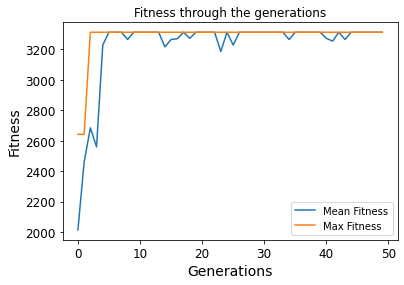

(50, 8, 1)


In [474]:
fitness_history_mean = [np.mean(fitness) for fitness in fitness_history]
fitness_history_max = [np.max(fitness) for fitness in fitness_history]
plt.plot(list(range(num_generations)), fitness_history_mean, label = 'Mean Fitness')
plt.plot(list(range(num_generations)), fitness_history_max, label = 'Max Fitness')
plt.legend()
plt.title('Fitness through the generations')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.show()
print(np.asarray(fitness_history).shape)

In [368]:
def cal_fitness(weight, value, population, threshold):
    
    fitness = np.empty(population.shape[0])
    
    for i in range(population.shape[0]):
        S1 = np.sum(population[i] * value)
        S2 = np.sum(population[i] * weight)
        if S2 <= threshold:
            fitness[i] = S1
        else:
            fitness[i] = 0 
    #print(fitness)

    return(pd.DataFrame({'fitness': fitness}))

In [464]:
# CROSS-OVER
def cross_over_mutation(solutions_per_pop, parents):
    
    #parents = selection_df;
    children = []
    desired_length = solutions_per_pop - len(parents)
 
    while len(children) < desired_length :
        male   = list(parents[random.randint(0,len(parents)-1)])
        female = list(parents[random.randint(0,len(parents)-1)])
        half = int(len(male)/2)
        child = male[:half] + female[half:]
        children.append(child)
        # print("=====================")
        
    mutation_chance = 0.08

    # Mutation
    for child in children:
        if mutation_chance > random.random():
            r = random.randint(0,len(child)-1)
            if child[r] == 1:
                child[r] = 0
            else:
                child[r] = 1
 
    population = np.concatenate([parents, children], axis = 0)
    return(population)

In [390]:
def selection(fitness_df, population, num_parents):
    
    # print(fitness_df)
    parents_df = fitness_df.sort_values('fitness', ascending=False).reset_index()[:num_parents]
    print(parents_df)
    parents    = population[parents_df['index']]
    return(parents)

# Traveling Salesman

*Given a list of cities and the distances between each pair of cities, what is the shortest possible route that visits each city and returns to the original city?*

https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35

<!-- *    Each suggested solution for a genetic algorithm is referred to as an **individual**. 
*    The collection of individuals is referred to as our **population**. 
*    Evolve a population from one **generation** to the next.

**Evolution:**

For each generation we take a portion of the best performing individuals as judged by our *fitness function*. These high-performers will be the parents of the next generation. We will also randomly select some lesser performing individuals to be parents, because we want to promote genetic diversity (=avoid getting stuck in a local maxima). 

Finally we **mutate** a small random portion of the population. What this means is to have a probability of randomly modifying each individual (= avoid getting stuck in a local maxima) -->